In [201]:
%load_ext autoreload
%autoreload complete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from protest_impact.util import cache, project_root
from tqdm.notebook import tqdm

plt.rcParams["figure.figsize"] = (4, 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


There might be some problems with the protest dates in the Magdeburg data. I only use Berlin. I have carefully checked manually that the protest dates are correct for Berlin.

In [202]:
from protest_impact.instrumental_variables.changes import load_useful_protests

cluster_terms, protests = load_useful_protests()
protests.shape

(21431, 34)

In [203]:
from protest_impact.instrumental_variables.changes import get_weather_changes

start, stop = -31, 31
weather_changes = get_weather_changes(
    protests[["event_date", "location"]], start=start, stop=stop, window=7, n_cores=4
)
protests = pd.concat([protests, weather_changes], axis=1)

  0%|          | 0/62 [00:00<?, ?it/s]

In [204]:
print(protests["location"].value_counts())
protests = protests[protests["location"] == "Berlin"]

Berlin       20750
Magdeburg      681
Name: location, dtype: int64


## Scale transformation and outlier removal

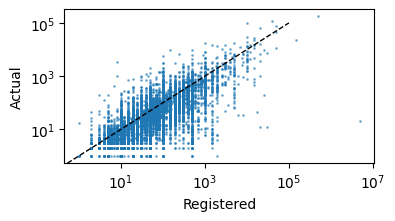

In [205]:
from protest_impact.instrumental_variables.changes import normal_overlay, plot_size_diff

plot_size_diff(protests)

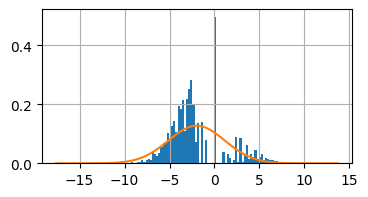

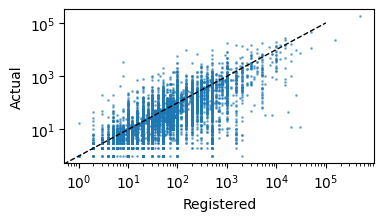

In [206]:
from protest_impact.instrumental_variables.changes import remove_outliers

protests["size_diff"] = np.arcsinh(protests["actual"] - protests["registered"])
protests = remove_outliers(protests, "size_diff", 4)
protests["size_diff"].hist(bins=100, density=True)
normal_overlay(protests["size_diff"])
plt.show()
plot_size_diff(protests)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


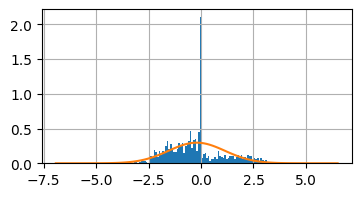

In [207]:
for i in range(start, stop):
    protests[f"prcp_change_{i}"] = np.arcsinh(protests[f"prcp_change_{i}"])
protests["prcp_change_0"].hist(bins=100, density=True)
normal_overlay(protests["prcp_change_0"])
plt.show()

## Some analysis

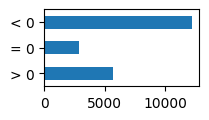

In [208]:
cat = pd.cut(
    protests["prcp_change_0"],
    [-np.inf, -1e-5, 1e-5, np.inf],
    labels=["< 0", "= 0", "> 0"],
)
cat.value_counts().loc[["> 0", "= 0", "< 0"]].plot.barh(figsize=(2, 1))
plt.show()

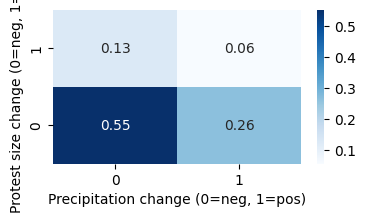

Accuracy: 0.61


In [209]:
matrix = [
    [
        protests.query("prcp_change_0 < 0 & size_diff < 0").shape[0],
        protests.query("prcp_change_0 > 0 & size_diff < 0").shape[0],
    ],
    [
        protests.query("prcp_change_0 < 0 & size_diff > 0").shape[0],
        protests.query("prcp_change_0 > 0 & size_diff > 0").shape[0],
    ],
]
matrix = np.array(matrix)
matrix = matrix / matrix.sum()
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues")
plt.gca().invert_yaxis()
plt.xlabel("Precipitation change (0=neg, 1=pos)")
plt.ylabel("Protest size change (0=neg, 1=pos)")
plt.show()
accuracy = matrix[0, 0] + matrix[1, 1] / matrix.sum()
print(f"Accuracy: {accuracy:.2f}")

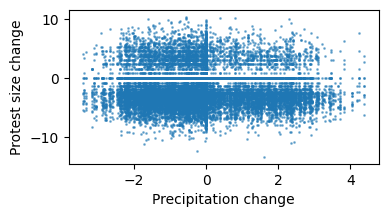

In [210]:
plt.scatter(protests["prcp_change_0"], protests["size_diff"], s=1, alpha=0.5)
plt.xlabel("Precipitation change")
plt.ylabel("Protest size change")
plt.show()

## Regression

In [211]:
# | label: tbl-change-regression-all
# | tbl-cap: Results for regression of change between registered and actual protest size on change between precipitation on the protest day and the week before the registration closes (2 days before the protest day). Demonstrations in Berlin with both registered and actual size > 0 have been included in the analysis. Outliers in size change are removed and both size and precipitation are transformed by the inverse hyperbolic sine function.
# | tbl-cap-location: margin

from protest_impact.instrumental_variables.changes import get_metrics

results = get_metrics(protests, 0, model_type=1, return_results=True)
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.3096,0.064,4.832,0.000,0.184,0.435
prcp_change_0,-0.0731,0.021,-3.436,0.001,-0.115,-0.031
registered,-1.5055,0.047,-31.858,0.000,-1.598,-1.413


## Residual analysis

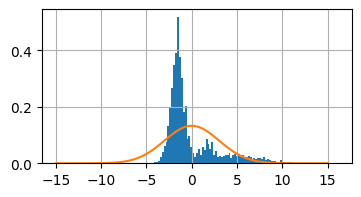

In [212]:
resids = results.resid
resids.hist(bins=100, density=True)
normal_overlay(resids)
plt.show()

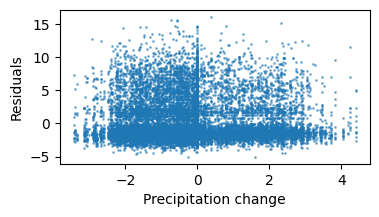

In [213]:
prcp_change = protests["prcp_change_0"]
plt.scatter(prcp_change, resids, s=1, alpha=0.5)
plt.xlabel("Precipitation change")
plt.ylabel("Residuals")
plt.show()

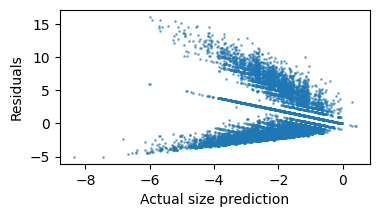

In [214]:
preds = results.predict()
plt.scatter(preds, resids, s=1, alpha=0.5)
plt.xlabel("Actual size prediction")
plt.ylabel("Residuals")
plt.show()

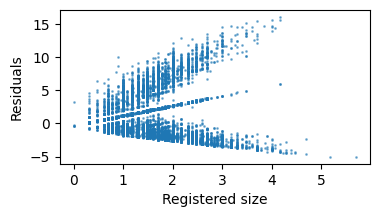

In [215]:
registered = np.log10(protests["registered"])
plt.scatter(registered, resids, s=1, alpha=0.5)
plt.xlabel("Registered size")
plt.ylabel("Residuals")
plt.show()

## Placebo tests

In [216]:
metrics = [get_metrics(protests, day) for day in tqdm(range(start, stop))]
metrics = pd.DataFrame(metrics)

  0%|          | 0/62 [00:00<?, ?it/s]

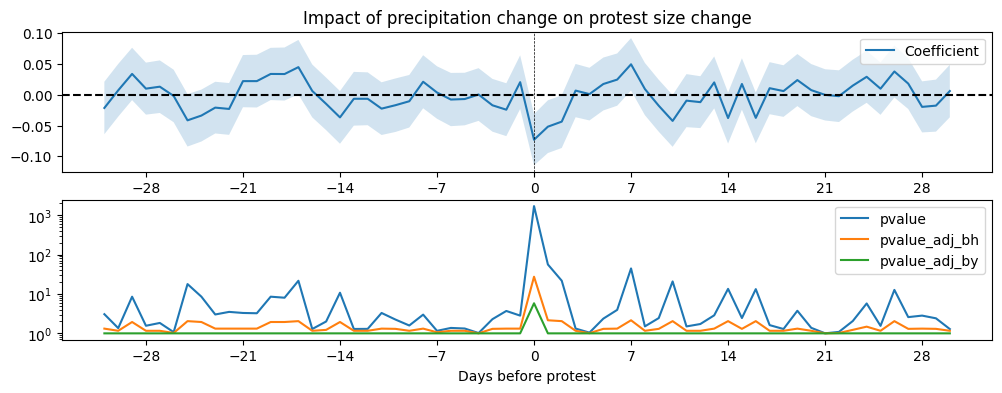

In [217]:
# | label: fig-change-regression-placebo
# | fig-cap: >
# |   Top: Placebo tests, where the change in protest size (between registered and actual numbers) is regressed on the precipitation change for the protest day (x=0) as well as every day of the previous and following month. The estimated coefficient and the 95% confidence interval are shown for each day.
# |   Bottom: P-values for the placebo tests from @fig-change-regression-placebo, original and adjusted for multiple comparisons using the Benjamini-Hochberg and Benjamini-Yekutieli procedures (the latter allows for correlations between the values). When using log-transformations rather than the inverse hyperbolic sine for the variables, p-values for $x\neq 0$ are more significant, and the p-value for x=14 is more significant than for x=0; I attribute that to random variation.
# | column: page

fig, axes = plt.subplots(2, 1)
ticks = [-28, -21, -14, -7, 0, 7, 14, 21, 28]
axes[0].set_xticks(ticks)
axes[0].plot(metrics["day"], metrics["coef"], label="Coefficient")
axes[0].fill_between(
    metrics["day"], metrics["ci_lower"], metrics["ci_upper"], alpha=0.2
)
axes[0].axhline(0, color="black", linestyle="--")
# axes[0].ylabel("Coefficient")
axes[0].set_title("Impact of precipitation change on protest size change")
axes[0].axvline(0, color="black", linestyle="--", linewidth=0.5)
axes[0].legend()

pvalues = metrics[["day", "pvalue"]].set_index("day").sort_index()
pvalues["pvalue_adj_bh"] = sm.stats.multipletests(pvalues["pvalue"], method="fdr_bh")[1]
pvalues["pvalue_adj_by"] = sm.stats.multipletests(pvalues["pvalue"], method="fdr_by")[1]
(1 / pvalues).plot(logy=True, ax=axes[1])
axes[1].set_xlabel("Days before protest")
axes[1].set_xticks(ticks)
plt.gcf().set_size_inches(12, 4)
plt.show()

## Analysis of placebo pattern

There is another rather significant spike 14 days after the protest date. The plots below show whether that is due to a cyclic pattern in the weather -- probably it is not.

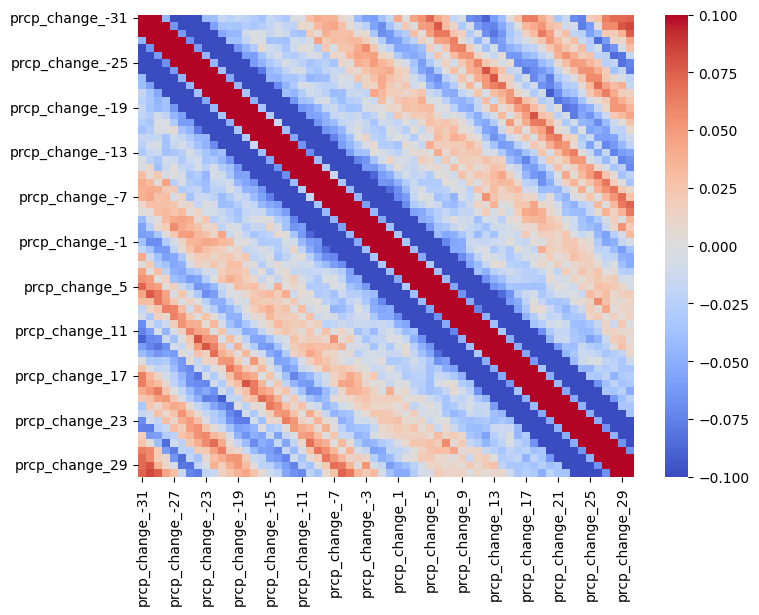

In [218]:
# correlation matric of prcp_change variables
corr = protests[[f"prcp_change_{i}" for i in range(start, stop)]].corr()
sns.heatmap(corr, cmap="coolwarm", vmin=-0.1, vmax=0.1)
plt.gcf().set_size_inches(8, 6)
plt.show()

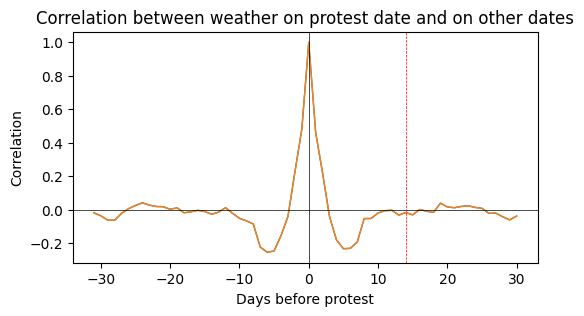

In [219]:
corr = protests[
    ["prcp_change_0"] + [f"prcp_change_{i}" for i in range(start, stop)]
].corr()
corr = corr["prcp_change_0"].iloc[1:]
plt.plot(range(start, stop), corr.values, linewidth=1)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.axvline(14, color="red", linestyle="--", linewidth=0.5)
plt.xlabel("Days before protest")
plt.ylabel("Correlation")
plt.title("Correlation between weather on protest date and on other dates")
plt.gcf().set_size_inches(6, 3)
plt.show()

## Climate protests

In [220]:
from itertools import chain

from protest_impact.data.protests import get_organization_labels

labels = get_organization_labels(protests, "climate")
protests["org"] = labels
climpro = protests[labels.notna()]
climpro.shape

(971, 98)

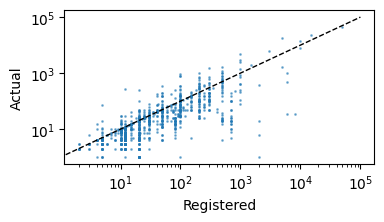

In [221]:
plot_size_diff(climpro)

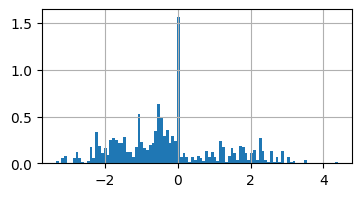

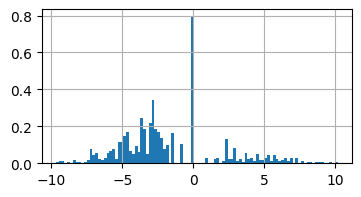

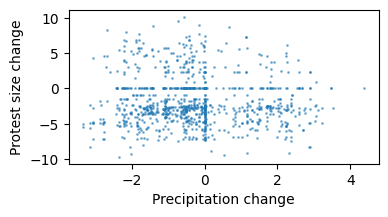

In [222]:
climpro["prcp_change_0"].hist(bins=100, density=True)
plt.show()
climpro["size_diff"].hist(bins=100, density=True)
plt.show()
plt.scatter(climpro["prcp_change_0"], climpro["size_diff"], s=1, alpha=0.5)
plt.xlabel("Precipitation change")
plt.ylabel("Protest size change")
plt.show()

In [223]:
# | label: tbl-change-regression-climate-reasonable
# | tbl-cap: Regression results for the first-stage model $\text{arcsinh}(\Delta \text{size}) = \beta_2\log_{10}(\text{size}_\text{registered}) + \beta_1\text{arcsinh}(\Delta \text{precipitation})+\epsilon$. This model is more _reasonable_ because it assumes a linear relationship between the (scaled) change in precipitation and the (scaled) change in protest size; but we cannot directly plug the dependent variable into the second stage.

from protest_impact.instrumental_variables.changes import get_metrics

results1 = get_metrics(climpro, 0, model_type=1, return_results=True)
results1.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0589,0.334,-0.176,0.860,-0.713,0.595
prcp_change_0,-0.2192,0.102,-2.156,0.031,-0.418,-0.020
registered,-1.1070,0.244,-4.539,0.000,-1.585,-0.629


In [224]:
# | label: tbl-change-regression-climate-useful
# | tbl-cap: Regression results for the first-stage model $\log_{10}(\text{size}_\text{actual}) = \beta_2\log_{10}(\text{size}_\text{registered}) + \beta_1\text{arcsinh}(\Delta \text{precipitation})+\epsilon$. This model is more useful because it directly predicts the desired variable $\log_{10}(\text{size}_\text{actual})$, which can be used for the second stage; but the effect of the precipitation change is not statistically significant at all.

from protest_impact.instrumental_variables.changes import get_metrics

results2 = get_metrics(climpro, 0, model_type=2, return_results=True)
results2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0298,0.046,-0.647,0.517,-0.120,0.060
prcp_change_0,-0.0044,0.015,-0.301,0.764,-0.033,0.024
registered,0.8411,0.032,25.900,0.000,0.777,0.905


## Second stage

For the usual 2-stage procedure, we need to aggregate the protest sizes by day and region, and make a linear model with the actual size as the dependent variable. This model will probably be worse than the original one.

In [225]:
# | label: tbl-change-regression-climate-useful-aggregated
# | tbl-cap: Same model but with protest size aggregated per day.

climagg = (
    climpro.groupby("event_date")
    .agg({"prcp_change_0": "mean", "registered": "sum", "actual": "sum"})
    .reset_index()
)

from protest_impact.instrumental_variables.changes import get_metrics

results = get_metrics(climagg, 0, model_type=2, return_results=True)
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0278,0.051,-0.543,0.587,-0.128,0.073
prcp_change_0,-0.0139,0.018,-0.771,0.441,-0.049,0.022
registered,0.8713,0.032,27.047,0.000,0.808,0.934


(15344, 41)
(1096, 41)


<Axes: xlabel='date'>

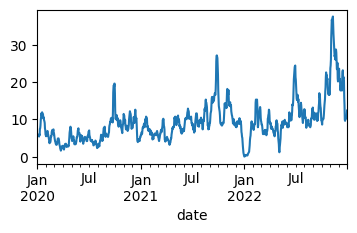

In [226]:
df = pd.read_csv(project_root / "data/daily_data.csv", parse_dates=["date"])
print(df.shape)
df = df.query("region == 'Berlin'")
print(df.shape)
topic = "climate_and_protest_mediacloud"
df = df[["date", topic]]
df = df.set_index("date")
df = df.rename(columns={topic: "coverage"})
df["coverage"].rolling(7).mean().plot()

<Axes: >

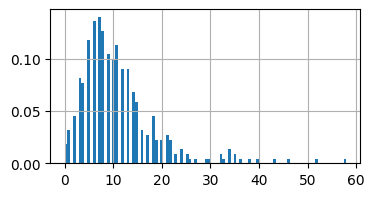

In [227]:
climagg = climagg.query(
    "event_date.dt.year >= 2020"
)  # in principle we also have earlier data
climagg["coverage"] = climagg.apply(
    lambda x: df.loc[
        x["event_date"] : x["event_date"] + pd.Timedelta(days=0), "coverage"
    ].mean(),
    axis=1,
)
climagg["coverage"].hist(bins=100, density=True)

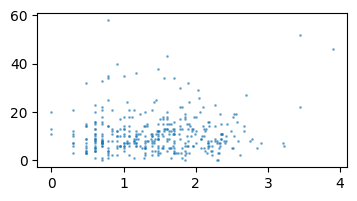

In [228]:
plt.scatter((np.log10(climagg["actual"])), climagg["coverage"], s=1, alpha=0.5)

In [229]:
# | label: tbl-change-liml-climate
# | tbl-cap: ...

from linearmodels.iv.model import IVLIML

df = climagg

model = IVLIML(
    dependent=df["coverage"],
    exog=np.log10(df["registered"]),
    endog=np.log10(df["actual"]),
    instruments=df["prcp_change_0"],
)
results = model.fit(cov_type="robust")
results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-LIML Estimation Summary                          
==============================================================================
Dep. Variable:               coverage   R-squared:                     -15.836
Estimator:                    IV-LIML   Adj. R-squared:                -15.925
No. Observations:                 379   F-statistic:                    8.1875
Date:                Mon, Jul 03 2023   P-value (F-stat)                0.0167
Time:                        16:16:06   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
registered     120.33     3849.0     0.0313     0.9751     -7423.6      7664.3
actual        -138.88     4662.7    -0.0298     0.9762     -9277.5      8999.8
==============================================================================

Endogenous: actual
Instruments: prcp_change_0
Robust Covariance (Heteroskedastic)
Debiased: False
Kappa: 1.000
"""

In [230]:
results.first_stage

,actual
R-squared,0.9372
Partial R-squared,2.529e-06
Shea's R-squared,2.529e-06
Partial F-statistic,0.0009
P-value (Partial F-stat),0.9757
Partial F-stat Distn,chi2(1)
==========================,===========
registered,0.8254
,(58.559)
prcp_change_0,-0.0005
